In [1]:
from cftime import DatetimeNoLeap
from datetime import timedelta
from numpy import datetime64, empty, float32, float64, full, repeat, stack
from os import chdir, system
from scipy.interpolate import griddata
from warnings import simplefilter
from xarray import DataArray, open_dataset
simplefilter("ignore")

In [2]:
start_year = 2015
start_month = 1
start_day = 1

In [3]:
end_year = 2015
end_month = 1
end_day = 8

**Paths**

In [4]:
nc_path = '/home/zhangc/cesm2_cmip6/nc_data/'
im_path = '/home/zhangc/cesm2_cmip6/im_data/'
os_path = '/home/zhangc/repositories/nc2im_cesm2/'

**Data**

In [5]:
ncs = ['ta_6hrLev_CESM2_ssp245_r2i1p1f1_gn_201501010000-202412311800.nc',     #  0
       'hus_6hrLev_CESM2_ssp245_r2i1p1f1_gn_201501010000-202412311800.nc',    #  1
       'ua_6hrLev_CESM2_ssp245_r2i1p1f1_gn_201501010000-202412311800.nc',     #  2
       'va_6hrLev_CESM2_ssp245_r2i1p1f1_gn_201501010000-202412311800.nc',     #  3
       'ps_6hrLev_CESM2_ssp245_r2i1p1f1_gn_201501010000-202412311800.nc',     #  4
       'tos_Oday_CESM2_ssp245_r2i1p1f1_gn_20150102-20650101.nc',              #  5
       'siconc_SIday_CESM2_ssp245_r2i1p1f1_gn_20150102-20650101.nc',          #  6
       'ts_Amon_CESM2_ssp245_r2i1p1f1_gn_201501-206412.nc',                   #  7
       'soil_mon_ERA5_2015.nc',                                               #  8
       'fracdata_0.9x1.25_gx1v6_c090317.nc',                                  #  9
       'USGS-gtopo30_0.9x1.25_remap_c051027.nc']                              # 10

In [6]:
chdir(nc_path)

In [7]:
dss = []
for nc in ncs:
    ds = open_dataset(nc)
    dss.append(ds)

**Time**

In [8]:
start_date = DatetimeNoLeap(start_year, start_month, start_day)
end_date = DatetimeNoLeap(end_year, end_month, end_day)

In [9]:
dates = []
date = start_date

In [10]:
while date <= end_date:
    dates.append(date)
    date += timedelta(hours=6)

In [11]:
date = dates[0]

In [12]:
tnum = date.year, date.month, date.day, date.hour
t6hr = DatetimeNoLeap(tnum[0], tnum[1], tnum[2], tnum[3])
tday = DatetimeNoLeap(tnum[0], tnum[1], tnum[2]) + timedelta(days=1)
if tnum[1] is 2:
    mid_day = 14
else:
    mid_day = 15
if tnum[1] in [1, 3, 5, 7, 8, 10, 12]:
    mid_hour = 12
else:
    mid_hour = 0
tmon = DatetimeNoLeap(tnum[0], tnum[1], mid_day, mid_hour)
tera = datetime64('2015-'+str(tnum[1]).zfill(2)+'-01')
file_time = str(t6hr).replace(' ', '_')

**Land-Sea Mask**

In [13]:
v = dss[9].LANDMASK.values
da = DataArray(name='ls', data=float32(v))
file_name = 'ls_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

**Soil Height**

In [36]:
dss[10].PHIS

<xarray.DataArray 'PHIS' (lat: 192, lon: 288)>
array([[27701.627574, 27701.627574, 27701.627574, ..., 27701.627574,
        27701.627574, 27701.627574],
       [26781.993496, 26801.877955, 26823.24702 , ..., 26731.480458,
        26746.794726, 26763.628318],
       [25888.717611, 25951.505898, 26014.836766, ..., 25705.620241,
        25765.581423, 25826.676211],
       ...,
       [    0.      ,     0.      ,     0.      , ...,     0.      ,
            0.      ,     0.      ],
       [    0.      ,     0.      ,     0.      , ...,     0.      ,
            0.      ,     0.      ],
       [    0.      ,     0.      ,     0.      , ...,     0.      ,
            0.      ,     0.      ]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    long_name:   surface geopotential
    units:       m2/s2
    from_hires:  true
    filter:      remap

In [41]:
a = dss[10].PHIS/9.81

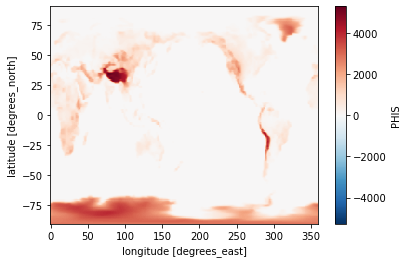

In [47]:
a.plot()

In [15]:
v = dss[10].PHIS.values/9.81
da = DataArray(name='sh', data=float32(v))
file_name = 'sh_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

**3D Temperature, Humidity, Winds**

In [16]:
for i in range(4):
    ds = dss[i].sel(time=t6hr).sortby('lev')
    vi = ds.variable_id
    v = ds[vi]
    v.attrs = {}
    v.values = float32(v.values)
    da = DataArray(name=vi, data=v)
    file_name = vi + '_' + file_time + '.nc'
    da.to_netcdf(im_path+file_name)

**Surface Pressure**

In [17]:
v = dss[4].ps.sel(time=t6hr).values
da = DataArray(name='ps', data=float32(v))
file_name = 'ps_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

**3D Virtual Temperature**

In [21]:
t = dss[0].ta.sel(time=t6hr).sortby('lev').values
q = dss[1].hus.sel(time=t6hr).sortby('lev').values
tv = t*(1.+q*0.61)
da = DataArray(name='tv', data=float32(tv)).transpose('dim_1', 'dim_2', 'dim_0')
file_name = 'tv_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

**3D Pressure**

In [23]:
ds = dss[0].ta.sel(time=t6hr).sortby('lev')
shape = ds.shape
lev = -ds.lev.values
p3 = empty(shape)
for i in range(len(lev)):
    p3[i] = full(shape[1:3], lev[i])
da = DataArray(name='p3', data=float32(p3)).transpose('dim_1', 'dim_2', 'dim_0')
file_name = 'p3_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

**2M Temperature, Humidity, Winds**

In [ ]:
ss = ['t2', 'q2', 'u2', 'v2']

In [ ]:
for i in range(4):
    vi = dss[i].variable_id
    v = dss[i][vi].sel(time=t6hr).isel(lev=-1).values
    da = DataArray(name=ss[i], data=float32(v))
    file_name = ss[i] + '_' + file_time + '.nc'
    da.to_netcdf(im_path+file_name)

**Skin Temperature**

In [ ]:
v = dss[7].ts.sel(time=tmon).values
da = DataArray(name='ts', data=float32(v))
file_name = 'ts_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

**Sea Level Pressure**

In [ ]:
ds = dss[0].ta.sel(time=t6hr).isel(lev=-1)
lev = ds.lev.values*-100
v = full(ds.shape, lev)
da = DataArray(name='p2', data=float32(v))
file_name = 'p2_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

**Sea Surface Temperature**

In [ ]:
ds = dss[5].tos.sel(time=tday)
x = ds.lon.values.flatten()
y = ds.lat.values.flatten()
xy = stack((x, y), axis=-1)
v = ds.values.flatten()

In [ ]:
lon1d = dss[0].lon.values
lat1d = dss[0].lat.values
nx = len(lon1d)
ny = len(lat1d)
lon2d = repeat(lon1d, ny).reshape(nx, ny).transpose()
lat2d = repeat(lat1d, nx).reshape(ny, nx)

In [ ]:
vi = griddata(xy, v, (lon2d, lat2d), method='linear')
da = DataArray(name='sst', data=float32(vi))
file_name = 'sst_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

**Sea Ice Concentration**

In [ ]:
da = dss[6].siconc.sel(time=tday)
v = da.values.flatten()
vi = griddata(xy, v, (lon2d, lat2d), method='linear')
da = DataArray(name='sic', data=float32(vi))
file_name = 'sic_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

**Soil Moisture, Temperature**

In [ ]:
ds = dss[8].sel(time=tera)
ss = ['swvl1', 'swvl2', 'swvl3', 'swvl4', 'stl1', 'stl2', 'stl3', 'stl4']

In [ ]:
for s in ss:
    v = ds[s].interp(longitude=lon1d, latitude=lat1d).values
    da = DataArray(name=s, data=float32(v))
    file_name = s + '_' + file_time + '.nc'
    da.to_netcdf(im_path+file_name)

In [ ]:
#chdir(os_path)

In [ ]:
#command = 'ncl convert_nc_to_im.ncl ' + "'file_time=" + '"' + file_time + '"' + "'"

In [ ]:
#system(command)